<a href="https://colab.research.google.com/github/adventurousAyan/AyanRepo/blob/master/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense,LSTM,GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from math import sqrt
from statsmodels.tsa.api import VAR
%matplotlib inline

In [6]:
class CustomEDA:     
    """Custom Exploratory Data Analysis Class"""    
    
    def fn_nulls_count(self, df):
        """Function to count the null values and their percentages in each column."""
        # Nulls counts in each column.
        nulls_counts = df.isnull().sum()
        # Convert above series into dataframe.
        nulls_counts_df = nulls_counts.to_frame(name = 'nulls_count')
        # Add a new column - to get the null counts percentage to the total rows.
        nulls_counts_df['nulls_percentage'] = round(100 * nulls_counts_df['nulls_count']/df.shape[0], 2)
        # Return the null counts dataframe.
        return nulls_counts_df
    
    def fn_plot_residuals(self, df):
        """Function to plot residuals in data."""
        # retrieve data as numpy array
        values = df.values
        print(values.shape)
        # create a subplot for each time series
        plt.figure(figsize=(16, 16))
        for i in range(values.shape[1]):
            plt.subplot(values.shape[1], 1, i+1)
            plt.plot(values[:, i])
        plt.show()
    
    
    def fn_compute_outliers(self, df):
        """Function to check for outliers in data."""
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        cleaned_eeg_df = df[~((df < (Q1 - 1.5 * IQR)) |
                                  (df > (Q3 + 1.5 * IQR)))\
                                .any(axis=1)]
        print(cleaned_eeg_df.shape)
    
    
    def fn_plot_correlation(self, df):
        """Function to plot the correlation in data."""
        plt.figure(figsize=(12,7))
        sns.heatmap(df.corr(), annot=True)
        plt.xticks(rotation=45)
        plt.show()
    
    def fn_check_and_drop_duplicates(self, df):
        """Function to check and drop duplicates in data."""
        duplicate = df[df.duplicated()]  
        print("Duplicate Rows :")  
        #Print the resultant Dataframe 
        duplicate 
        df_duplicates_removed = pd.DataFrame.drop_duplicates(df)
        print(df_duplicates_removed)
        return df_duplicates_removed
       
    def fn_fetch_col_based_ontype(self, df, *args):
        """Function to return column based on column type"""
        return df.select_dtypes(include=args).columns.tolist()
    
    def fn_get_data_information(self, df):
        """Function to fetch data-frame information"""
        print(f'Shape of dataframe is {df.shape}')
        print('*************************************************************')
        print("DataFrame information")
        print(df.info())
        print('************************************************************')
        print("DataFrame Summary")
        print(df.describe())
        
    def fn_plot_pairplots(self, df, targetCol):
        for i in range(0, len(df.columns), 5):
                sns.pairplot(data=df,
                x_vars=df.columns[i:i+5],
                y_vars=[targetCol])
                
    def fn_plot_regplot(self, df, features_to_analyse, targetCol):
        fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))
        for i, ax in enumerate(fig.axes):
            if i < len(features_to_analyse) - 1:
                sns.regplot(x=features_to_analyse[i],y=targetCol, data=df[features_to_analyse], ax=ax)
                
    def fn_plot_countplot(self, df_not_num):
        fig, axes = plt.subplots(round(len(df_not_num.columns) / 3), 3, figsize=(12, 30))
        for i, ax in enumerate(fig.axes):
            if i < len(df_not_num.columns):
                ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
                sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)
        fig.tight_layout() 
    
    def fn_plot_histplot(self, df_num):
        df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);
        
    def fn_nulls_plot(self,df):
        plt.figure(figsize = (12,6))
        sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
        plt.xticks(rotation=45)
        plt.show()

In [7]:
eda = CustomEDA()

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/train_data.csv")
farm_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/farm_data.csv")
weather_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/train_weather.csv")

In [10]:
train_farm = pd.merge(data, farm_data, on='farm_id')

In [11]:
weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [12]:
train_farm.columns = ['timestamp', 'farm_id', 'ingredient_type', 'yield',
       'operations_commencing_year', 'num_processing_plants', 'farm_area',
       'farming_company', 'deidentified_location']

In [13]:
train_farm['timestamp'] = pd.to_datetime(train_farm['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [14]:
train_farm['timestamp'] = pd.to_datetime(train_farm['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [15]:
final_data = pd.merge(train_farm, weather_data , on=['timestamp', 'deidentified_location'])

In [16]:
final_data.drop(['num_processing_plants', 'operations_commencing_year'], axis=1,inplace=True)

In [17]:
final_data.set_index('timestamp', inplace=True)

In [18]:
# final_data = final_data.assign(precipitation=final_data['precipitation'].interpolate(method='time'))

In [19]:
# final_data = final_data.assign(wind_speed=final_data['wind_speed'].interpolate(method='time'))
# final_data = final_data.assign(pressure_sea_level=final_data['pressure_sea_level'].interpolate(method='time'))
# final_data = final_data.assign(dew_temp=final_data['dew_temp'].interpolate(method='time'))

In [20]:
final_data['precipitation'].fillna(final_data['precipitation'].mean(), inplace = True)
final_data['pressure_sea_level'].fillna(final_data['pressure_sea_level'].mean(), inplace = True)
final_data['wind_speed'].fillna(final_data['wind_speed'].mean(), inplace = True)
final_data['dew_temp'].fillna(final_data['dew_temp'].mean(), inplace = True)

In [21]:
final_data.drop(['wind_direction', 'temp_obs','cloudiness'], axis=1, inplace=True)

In [22]:
final_data.head()

,farm_id,ingredient_type,yield,farm_area,farming_company,deidentified_location,dew_temp,pressure_sea_level,precipitation,wind_speed
timestamp,,,,,,,,,,
2016-01-01,fid_110884,ing_w,0.0,690.455096,Obery Farms,location 7369,20.0,1019.7,0.793987,0.0
2016-01-01,fid_90053,ing_w,0.0,252.696160,Obery Farms,location 7369,20.0,1019.7,0.793987,0.0
2016-01-01,fid_17537,ing_w,0.0,499.446528,Obery Farms,location 7369,20.0,1019.7,0.793987,0.0
2016-01-01,fid_110392,ing_w,0.0,2200.407555,Obery Farms,location 7369,20.0,1019.7,0.793987,0.0
2016-01-01,fid_62402,ing_w,0.0,10833.140121,Obery Farms,location 7369,20.0,1019.7,0.793987,0.0


In [23]:
def fn_build_model(farm_id):
  pass



In [24]:
df = final_data[final_data.farm_id == 'fid_110884']

In [25]:
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/test_data.csv")
#farm_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/farm_data.csv")
test_weather = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/test_weather.csv")

In [26]:
test_data.shape

(20848800, 4)

In [27]:
test_weather.shape

(138825, 9)

In [28]:
test_data.head()

,date,farm_id,ingredient_type,id
0,2017-01-01 00:00:00,fid_110884,ing_w,0
1,2017-01-01 00:00:00,fid_90053,ing_w,1
2,2017-01-01 00:00:00,fid_17537,ing_w,2
3,2017-01-01 00:00:00,fid_110392,ing_w,3
4,2017-01-01 00:00:00,fid_62402,ing_w,4


In [29]:
test_farm = pd.merge(test_data, farm_data, on='farm_id')

In [30]:
test_weather['timestamp'] = pd.to_datetime(test_weather['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [31]:
test_weather.head()

,timestamp,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed
0,2017-01-01 00:00:00,location 7369,17.8,4.0,100.0,11.7,1021.4,NaN,3.6
1,2017-01-01 01:00:00,location 7369,17.8,2.0,130.0,12.8,1022.0,0.0,3.1
2,2017-01-01 02:00:00,location 7369,16.1,0.0,140.0,12.8,1021.9,0.0,3.1
3,2017-01-01 03:00:00,location 7369,17.2,0.0,140.0,13.3,1022.2,0.0,3.1
4,2017-01-01 04:00:00,location 7369,16.7,2.0,130.0,13.3,1022.3,0.0,2.6


In [32]:
test_farm.columns

Index(['date', 'farm_id', 'ingredient_type', 'id',
       'operations_commencing_year', 'num_processing_plants', 'farm_area',
       'farming_company', 'deidentified_location'],
      dtype='object')

In [33]:
test_farm.head()

,date,farm_id,ingredient_type,id,operations_commencing_year,num_processing_plants,farm_area,farming_company,deidentified_location
0,2017-01-01 00:00:00,fid_110884,ing_w,0,2008.0,NaN,690.455096,Obery Farms,location 7369
1,2017-01-01 01:00:00,fid_110884,ing_w,129,2008.0,NaN,690.455096,Obery Farms,location 7369
2,2017-01-01 02:00:00,fid_110884,ing_w,258,2008.0,NaN,690.455096,Obery Farms,location 7369
3,2017-01-01 03:00:00,fid_110884,ing_w,387,2008.0,NaN,690.455096,Obery Farms,location 7369
4,2017-01-01 04:00:00,fid_110884,ing_w,516,2008.0,NaN,690.455096,Obery Farms,location 7369


In [34]:
test_farm.columns = ['timestamp', 'farm_id', 'ingredient_type', 'id',
       'operations_commencing_year', 'num_processing_plants', 'farm_area',
       'farming_company', 'deidentified_location']

In [35]:
test_farm['timestamp'] = pd.to_datetime(test_farm['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [36]:
test_farm.reset_index(inplace=True)

In [37]:
test_weather.reset_index(inplace=True)

In [38]:
test_weather.drop('index', axis=1, inplace=True)

In [39]:
test_farm.drop('index', axis=1, inplace=True)

In [40]:
test_farm.head()

,timestamp,farm_id,ingredient_type,id,operations_commencing_year,num_processing_plants,farm_area,farming_company,deidentified_location
0,2017-01-01 00:00:00,fid_110884,ing_w,0,2008.0,NaN,690.455096,Obery Farms,location 7369
1,2017-01-01 01:00:00,fid_110884,ing_w,129,2008.0,NaN,690.455096,Obery Farms,location 7369
2,2017-01-01 02:00:00,fid_110884,ing_w,258,2008.0,NaN,690.455096,Obery Farms,location 7369
3,2017-01-01 03:00:00,fid_110884,ing_w,387,2008.0,NaN,690.455096,Obery Farms,location 7369
4,2017-01-01 04:00:00,fid_110884,ing_w,516,2008.0,NaN,690.455096,Obery Farms,location 7369


In [41]:
test_weather.head()

,timestamp,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed
0,2017-01-01 00:00:00,location 7369,17.8,4.0,100.0,11.7,1021.4,NaN,3.6
1,2017-01-01 01:00:00,location 7369,17.8,2.0,130.0,12.8,1022.0,0.0,3.1
2,2017-01-01 02:00:00,location 7369,16.1,0.0,140.0,12.8,1021.9,0.0,3.1
3,2017-01-01 03:00:00,location 7369,17.2,0.0,140.0,13.3,1022.2,0.0,3.1
4,2017-01-01 04:00:00,location 7369,16.7,2.0,130.0,13.3,1022.3,0.0,2.6


In [42]:
test_weather.columns

Index(['timestamp', 'deidentified_location', 'temp_obs', 'cloudiness',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed'],
      dtype='object')

In [43]:
test_farm.columns

Index(['timestamp', 'farm_id', 'ingredient_type', 'id',
       'operations_commencing_year', 'num_processing_plants', 'farm_area',
       'farming_company', 'deidentified_location'],
      dtype='object')

In [44]:
final_test_data = pd.merge(test_weather, test_farm , on=['timestamp', 'deidentified_location'])

In [45]:
final_test_data.shape

(21154797, 16)

In [46]:
final_test_data.set_index('timestamp', inplace=True)

In [47]:
final_test_data.drop(['num_processing_plants', 'operations_commencing_year'], axis=1,inplace=True)

In [48]:
final_test_data['precipitation'].fillna(final_test_data['precipitation'].mean(), inplace = True)
final_test_data['pressure_sea_level'].fillna(final_test_data['pressure_sea_level'].mean(), inplace = True)
final_test_data['wind_speed'].fillna(final_test_data['wind_speed'].mean(), inplace = True)
final_test_data['dew_temp'].fillna(final_test_data['dew_temp'].mean(), inplace = True)

In [49]:
test_farm.head()

,timestamp,farm_id,ingredient_type,id,operations_commencing_year,num_processing_plants,farm_area,farming_company,deidentified_location
0,2017-01-01 00:00:00,fid_110884,ing_w,0,2008.0,NaN,690.455096,Obery Farms,location 7369
1,2017-01-01 01:00:00,fid_110884,ing_w,129,2008.0,NaN,690.455096,Obery Farms,location 7369
2,2017-01-01 02:00:00,fid_110884,ing_w,258,2008.0,NaN,690.455096,Obery Farms,location 7369
3,2017-01-01 03:00:00,fid_110884,ing_w,387,2008.0,NaN,690.455096,Obery Farms,location 7369
4,2017-01-01 04:00:00,fid_110884,ing_w,516,2008.0,NaN,690.455096,Obery Farms,location 7369


In [50]:
test_weather.head()

,timestamp,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed
0,2017-01-01 00:00:00,location 7369,17.8,4.0,100.0,11.7,1021.4,NaN,3.6
1,2017-01-01 01:00:00,location 7369,17.8,2.0,130.0,12.8,1022.0,0.0,3.1
2,2017-01-01 02:00:00,location 7369,16.1,0.0,140.0,12.8,1021.9,0.0,3.1
3,2017-01-01 03:00:00,location 7369,17.2,0.0,140.0,13.3,1022.2,0.0,3.1
4,2017-01-01 04:00:00,location 7369,16.7,2.0,130.0,13.3,1022.3,0.0,2.6


In [51]:
test_weather.columns

Index(['timestamp', 'deidentified_location', 'temp_obs', 'cloudiness',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed'],
      dtype='object')

In [52]:
test_farm.columns

Index(['timestamp', 'farm_id', 'ingredient_type', 'id',
       'operations_commencing_year', 'num_processing_plants', 'farm_area',
       'farming_company', 'deidentified_location'],
      dtype='object')

In [ ]:
df.drop('farm_id', axis=1, inplace=True)

In [48]:
df = final_data[final_data.farm_id == 'fid_90053']
df_test = final_test_data[final_test_data.farm_id == 'fid_90053']

#df_test['yield'] = 0



In [49]:
df.head()

,farm_id,ingredient_type,yield,farm_area,farming_company,deidentified_location,dew_temp,pressure_sea_level,precipitation,wind_speed
timestamp,,,,,,,,,,
2016-01-01 00:00:00,fid_90053,ing_w,0.0,252.69616,Obery Farms,location 7369,20.0,1019.7,0.793987,0.0
2016-01-01 01:00:00,fid_90053,ing_w,0.0,252.69616,Obery Farms,location 7369,21.1,1020.2,-1.000000,1.5
2016-01-01 02:00:00,fid_90053,ing_w,0.0,252.69616,Obery Farms,location 7369,21.1,1020.2,0.000000,0.0
2016-01-01 03:00:00,fid_90053,ing_w,0.0,252.69616,Obery Farms,location 7369,20.6,1020.1,0.000000,0.0
2016-01-01 04:00:00,fid_90053,ing_w,0.0,252.69616,Obery Farms,location 7369,20.0,1020.0,-1.000000,2.6


In [50]:
df_test = df_test[['ingredient_type','dew_temp','pressure_sea_level','precipitation','wind_speed']]

In [51]:
df_test['yield'] = 0

In [52]:
df.columns

col = df.pop("yield")
df.insert(0, col.name, col)
df.head()

,yield,farm_id,ingredient_type,farm_area,farming_company,deidentified_location,dew_temp,pressure_sea_level,precipitation,wind_speed
timestamp,,,,,,,,,,
2016-01-01 00:00:00,0.0,fid_90053,ing_w,252.69616,Obery Farms,location 7369,20.0,1019.7,0.793987,0.0
2016-01-01 01:00:00,0.0,fid_90053,ing_w,252.69616,Obery Farms,location 7369,21.1,1020.2,-1.000000,1.5
2016-01-01 02:00:00,0.0,fid_90053,ing_w,252.69616,Obery Farms,location 7369,21.1,1020.2,0.000000,0.0
2016-01-01 03:00:00,0.0,fid_90053,ing_w,252.69616,Obery Farms,location 7369,20.6,1020.1,0.000000,0.0
2016-01-01 04:00:00,0.0,fid_90053,ing_w,252.69616,Obery Farms,location 7369,20.0,1020.0,-1.000000,2.6


In [53]:
df_test.columns

col = df_test.pop("yield")
df_test.insert(0, col.name, col)
df_test.head()

,yield,ingredient_type,dew_temp,pressure_sea_level,precipitation,wind_speed
timestamp,,,,,,
2017-01-01 00:00:00,0,ing_w,11.7,1021.4,0.808699,3.6
2017-01-01 01:00:00,0,ing_w,12.8,1022.0,0.000000,3.1
2017-01-01 02:00:00,0,ing_w,12.8,1021.9,0.000000,3.1
2017-01-01 03:00:00,0,ing_w,13.3,1022.2,0.000000,3.1
2017-01-01 04:00:00,0,ing_w,13.3,1022.3,0.000000,2.6


In [54]:
df_test.columns

col = df_test.pop("yield")
df_test.insert(0, col.name, col)
df_test.head()

,yield,ingredient_type,dew_temp,pressure_sea_level,precipitation,wind_speed
timestamp,,,,,,
2017-01-01 00:00:00,0,ing_w,11.7,1021.4,0.808699,3.6
2017-01-01 01:00:00,0,ing_w,12.8,1022.0,0.000000,3.1
2017-01-01 02:00:00,0,ing_w,12.8,1021.9,0.000000,3.1
2017-01-01 03:00:00,0,ing_w,13.3,1022.2,0.000000,3.1
2017-01-01 04:00:00,0,ing_w,13.3,1022.3,0.000000,2.6


In [55]:
df = df.append(df_test)

In [56]:
df.head()

,yield,farm_id,ingredient_type,farm_area,farming_company,deidentified_location,dew_temp,pressure_sea_level,precipitation,wind_speed
timestamp,,,,,,,,,,
2016-01-01 00:00:00,0.0,fid_90053,ing_w,252.69616,Obery Farms,location 7369,20.0,1019.7,0.793987,0.0
2016-01-01 01:00:00,0.0,fid_90053,ing_w,252.69616,Obery Farms,location 7369,21.1,1020.2,-1.000000,1.5
2016-01-01 02:00:00,0.0,fid_90053,ing_w,252.69616,Obery Farms,location 7369,21.1,1020.2,0.000000,0.0
2016-01-01 03:00:00,0.0,fid_90053,ing_w,252.69616,Obery Farms,location 7369,20.6,1020.1,0.000000,0.0
2016-01-01 04:00:00,0.0,fid_90053,ing_w,252.69616,Obery Farms,location 7369,20.0,1020.0,-1.000000,2.6


In [61]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [58]:
df.drop(['deidentified_location', 'farming_company','farm_area'], axis=1, inplace=True)

In [59]:
df.columns

col = df.pop("yield")
df.insert(0, col.name, col)
df.head()

,yield,farm_id,ingredient_type,dew_temp,pressure_sea_level,precipitation,wind_speed
timestamp,,,,,,,
2016-01-01 00:00:00,0.0,fid_90053,ing_w,20.0,1019.7,0.793987,0.0
2016-01-01 01:00:00,0.0,fid_90053,ing_w,21.1,1020.2,-1.000000,1.5
2016-01-01 02:00:00,0.0,fid_90053,ing_w,21.1,1020.2,0.000000,0.0
2016-01-01 03:00:00,0.0,fid_90053,ing_w,20.6,1020.1,0.000000,0.0
2016-01-01 04:00:00,0.0,fid_90053,ing_w,20.0,1020.0,-1.000000,2.6


In [60]:
df.drop('farm_id', axis=1, inplace=True)

In [61]:
labelEncoder = LabelEncoder()
df['ingredient_type'] = labelEncoder.fit_transform(df['ingredient_type'])
values = df.values
print(values.shape)
values = values.astype('float32')

(17544, 6)


In [62]:
df.shape

(17544, 6)

In [63]:
series_to_supervised(values,1,1)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
1,0.0,0.0,20.0,1019.700012,0.793987,0.0,0.0,0.0,21.1,1020.200012,-1.0,1.5
2,0.0,0.0,21.1,1020.200012,-1.000000,1.5,0.0,0.0,21.1,1020.200012,0.0,0.0
3,0.0,0.0,21.1,1020.200012,0.000000,0.0,0.0,0.0,20.6,1020.099976,0.0,0.0
4,0.0,0.0,20.6,1020.099976,0.000000,0.0,0.0,0.0,20.0,1020.000000,-1.0,2.6
5,0.0,0.0,20.0,1020.000000,-1.000000,2.6,0.0,0.0,19.4,1016.084717,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17539,0.0,0.0,6.7,1021.099976,0.000000,0.0,0.0,0.0,7.2,1019.400024,0.0,2.6
17540,0.0,0.0,7.2,1019.400024,0.000000,2.6,0.0,0.0,8.3,1019.099976,0.0,1.5
17541,0.0,0.0,8.3,1019.099976,0.000000,1.5,0.0,0.0,8.9,1019.200012,0.0,1.5
17542,0.0,0.0,8.9,1019.200012,0.000000,1.5,0.0,0.0,8.9,1019.200012,0.0,1.5


In [64]:
reframed = series_to_supervised(values,1,1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.0,0.0,20.0,1019.700012,0.793987,0.0,0.0
2,0.0,0.0,21.1,1020.200012,-1.000000,1.5,0.0
3,0.0,0.0,21.1,1020.200012,0.000000,0.0,0.0
4,0.0,0.0,20.6,1020.099976,0.000000,0.0,0.0
5,0.0,0.0,20.0,1020.000000,-1.000000,2.6,0.0


In [65]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled,1,1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.0,0.0,0.820375,0.699820,0.003000,0.000000,0.0
2,0.0,0.0,0.849866,0.708860,0.000000,0.061983,0.0
3,0.0,0.0,0.849866,0.708860,0.001672,0.000000,0.0
4,0.0,0.0,0.836461,0.707052,0.001672,0.000000,0.0
5,0.0,0.0,0.820375,0.705244,0.000000,0.107438,0.0


In [66]:
values = reframed.values
n_train = 366*24
train = values[:n_train]
test = values[n_train:]


In [67]:
train[:,:]

array([[0.        , 0.        , 0.8203753 , ..., 0.00299998, 0.        ,
        0.        ],
       [0.        , 0.        , 0.8498659 , ..., 0.        , 0.06198347,
        0.        ],
       [0.        , 0.        , 0.8498659 , ..., 0.00167224, 0.        ,
        0.        ],
       ...,
       [0.20985374, 0.        , 0.5522788 , ..., 0.00167224, 0.16942148,
        0.21306589],
       [0.21306589, 0.        , 0.5522788 , ..., 0.00167224, 0.12809917,
        0.20021766],
       [0.20021766, 0.        , 0.5522788 , ..., 0.00167224, 0.        ,
        0.        ]], dtype=float32)

In [68]:
trainX,trainY = train[:,:-1],train[:,-1]
testX,testY = test[:,:-1],test[:,-1]

In [69]:
print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(8784, 6) (8784,) (8759, 6) (8759,)


In [70]:
print(trainX.shape)
print(testX.shape)

(8784, 6)
(8759, 6)


In [71]:
trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
testX = testX.reshape(testX.shape[0],1,testX.shape[1])

In [72]:
stop_noimprovement = EarlyStopping(patience=10)
model = Sequential()
model.add(LSTM(50,input_shape=(trainX.shape[1],trainX.shape[2]),dropout=0.2))
model.add(Dense(1))
model.compile(loss="mae",optimizer="adam")

In [73]:
history= model.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,verbose=2,callbacks=[stop_noimprovement],shuffle=False)

Epoch 1/100
275/275 - 4s - loss: 0.0870 - val_loss: 0.3183
Epoch 2/100
275/275 - 1s - loss: 0.1070 - val_loss: 0.2831
Epoch 3/100
275/275 - 1s - loss: 0.1024 - val_loss: 0.2570
Epoch 4/100
275/275 - 1s - loss: 0.0981 - val_loss: 0.2391
Epoch 5/100
275/275 - 1s - loss: 0.0952 - val_loss: 0.2326
Epoch 6/100
275/275 - 1s - loss: 0.0938 - val_loss: 0.2230
Epoch 7/100
275/275 - 1s - loss: 0.0924 - val_loss: 0.2213
Epoch 8/100
275/275 - 1s - loss: 0.0933 - val_loss: 0.2146
Epoch 9/100
275/275 - 1s - loss: 0.0936 - val_loss: 0.2069
Epoch 10/100
275/275 - 1s - loss: 0.0902 - val_loss: 0.2038
Epoch 11/100
275/275 - 1s - loss: 0.0911 - val_loss: 0.1977
Epoch 12/100
275/275 - 1s - loss: 0.0892 - val_loss: 0.1944
Epoch 13/100
275/275 - 1s - loss: 0.0873 - val_loss: 0.1910
Epoch 14/100
275/275 - 1s - loss: 0.0873 - val_loss: 0.1857
Epoch 15/100
275/275 - 1s - loss: 0.0882 - val_loss: 0.1847
Epoch 16/100
275/275 - 1s - loss: 0.0857 - val_loss: 0.1800
Epoch 17/100
275/275 - 1s - loss: 0.0868 - val_lo

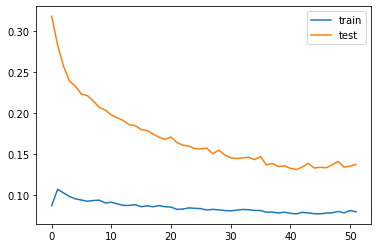

In [74]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

In [75]:
predicted = model.predict(testX)

In [76]:
testXRe = testX.reshape(testX.shape[0],testX.shape[2])

In [77]:
predicted = np.concatenate((predicted,testXRe[:,1:]),axis=1)

In [78]:
#scaler = MinMaxScaler(feature_range=(0,1))
#scaler.fit(predicted)

In [79]:
predicted = scaler.inverse_transform(predicted)

In [80]:
testY = testY.reshape(len(testY),1)

In [81]:
testY = np.concatenate((testY,testXRe[:,1:]),axis=1)

In [82]:
#scaler = MinMaxScaler(feature_range=(0,1))
#scaler.fit(testY)

In [83]:
testY = scaler.inverse_transform(testY)

In [84]:
pd.DataFrame(testY)

,0,1,2,3,4,5
0,0.0,0.0,11.700000,1021.400024,0.808699,3.6
1,0.0,0.0,12.799999,1021.999939,0.000000,3.1
2,0.0,0.0,12.799999,1021.900085,0.000000,3.1
3,0.0,0.0,13.300000,1022.200073,0.000000,3.1
4,0.0,0.0,13.300000,1022.300049,0.000000,2.6
...,...,...,...,...,...,...
8754,0.0,0.0,6.700000,1021.099915,0.000000,0.0
8755,0.0,0.0,7.199999,1019.400085,0.000000,2.6
8756,0.0,0.0,8.300001,1019.099976,0.000000,1.5
8757,0.0,0.0,8.899999,1019.199951,0.000000,1.5


In [85]:
np.sqrt(mean_squared_error(testY[:,0],predicted[:,0]))

35.099564

In [86]:
result = pd.concat([pd.Series(predicted[:,0]),pd.Series(testY[:,0])],axis=1)
result.columns = ['thetahat','theta']
result['diff'] = result['thetahat'] - result['theta']

In [87]:
result

,thetahat,theta,diff
0,32.438843,0.0,32.438843
1,32.876312,0.0,32.876312
2,32.866219,0.0,32.866219
3,33.109535,0.0,33.109535
4,33.046215,0.0,33.046215
...,...,...,...
8754,30.028360,0.0,30.028360
8755,30.436867,0.0,30.436867
8756,30.577642,0.0,30.577642
8757,30.798544,0.0,30.798544


In [88]:
df_test2 = final_test_data[final_test_data.farm_id == 'fid_90053']

In [89]:
final_test_data.head()

,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,farm_id,ingredient_type,id,farm_area,farming_company
timestamp,,,,,,,,,,,,,
2017-01-01,location 7369,17.8,4.0,100.0,11.7,1021.4,0.808699,3.6,fid_110884,ing_w,0,690.455096,Obery Farms
2017-01-01,location 7369,17.8,4.0,100.0,11.7,1021.4,0.808699,3.6,fid_90053,ing_w,1,252.696160,Obery Farms
2017-01-01,location 7369,17.8,4.0,100.0,11.7,1021.4,0.808699,3.6,fid_17537,ing_w,2,499.446528,Obery Farms
2017-01-01,location 7369,17.8,4.0,100.0,11.7,1021.4,0.808699,3.6,fid_110392,ing_w,3,2200.407555,Obery Farms
2017-01-01,location 7369,17.8,4.0,100.0,11.7,1021.4,0.808699,3.6,fid_62402,ing_w,4,10833.140121,Obery Farms


In [90]:
predicted.shape

(8759, 6)

In [91]:
df_test2.head()

,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,farm_id,ingredient_type,id,farm_area,farming_company
timestamp,,,,,,,,,,,,,
2017-01-01 00:00:00,location 7369,17.8,4.0,100.0,11.7,1021.4,0.808699,3.6,fid_90053,ing_w,1,252.69616,Obery Farms
2017-01-01 01:00:00,location 7369,17.8,2.0,130.0,12.8,1022.0,0.000000,3.1,fid_90053,ing_w,130,252.69616,Obery Farms
2017-01-01 02:00:00,location 7369,16.1,0.0,140.0,12.8,1021.9,0.000000,3.1,fid_90053,ing_w,259,252.69616,Obery Farms
2017-01-01 03:00:00,location 7369,17.2,0.0,140.0,13.3,1022.2,0.000000,3.1,fid_90053,ing_w,388,252.69616,Obery Farms
2017-01-01 04:00:00,location 7369,16.7,2.0,130.0,13.3,1022.3,0.000000,2.6,fid_90053,ing_w,517,252.69616,Obery Farms


In [92]:
df_test2.id.nunique()

8760

In [93]:
temp_df= pd.DataFrame({'id': df_test2.id[:df_test2.shape[0]-1], 'yield': predicted[:,0]})

In [94]:
temp_df.head()

,id,yield
timestamp,,
2017-01-01 00:00:00,1,32.438843
2017-01-01 01:00:00,130,32.876312
2017-01-01 02:00:00,259,32.866219
2017-01-01 03:00:00,388,33.109535
2017-01-01 04:00:00,517,33.046215


In [ ]:
df_test = final_test_data[final_test_data.farm_id == 'fid_110884']

In [ ]:
df_test.head()

,deidentified_location,dew_temp,pressure_sea_level,precipitation,wind_speed,farm_id,ingredient_type,id,farm_area,farming_company
timestamp,,,,,,,,,,
2017-01-01 00:00:00,location 7369,11.7,1021.4,0.808699,3.6,fid_110884,ing_w,0,690.455096,Obery Farms
2017-01-01 01:00:00,location 7369,12.8,1022.0,0.000000,3.1,fid_110884,ing_w,129,690.455096,Obery Farms
2017-01-01 02:00:00,location 7369,12.8,1021.9,0.000000,3.1,fid_110884,ing_w,258,690.455096,Obery Farms
2017-01-01 03:00:00,location 7369,13.3,1022.2,0.000000,3.1,fid_110884,ing_w,387,690.455096,Obery Farms
2017-01-01 04:00:00,location 7369,13.3,1022.3,0.000000,2.6,fid_110884,ing_w,516,690.455096,Obery Farms


In [ ]:
df_test.drop(['deidentified_location', 'farming_company','farm_area'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_test2 = df_test.copy()

In [ ]:
df_test2.drop(['farm_id','id'], axis=1, inplace=True)

In [ ]:
df_test2.head()

,dew_temp,pressure_sea_level,precipitation,wind_speed,ingredient_type
timestamp,,,,,
2017-01-01 00:00:00,11.7,1021.4,0.808699,3.6,ing_w
2017-01-01 01:00:00,12.8,1022.0,0.000000,3.1,ing_w
2017-01-01 02:00:00,12.8,1021.9,0.000000,3.1,ing_w
2017-01-01 03:00:00,13.3,1022.2,0.000000,3.1,ing_w
2017-01-01 04:00:00,13.3,1022.3,0.000000,2.6,ing_w


In [ ]:
df_test2 = df_test2[['ingredient_type','dew_temp','pressure_sea_level','precipitation','wind_speed']]

In [ ]:
df_test2['yield'] = 0

In [ ]:
df.columns

col = df_test2.pop("yield")
df_test2.insert(0, col.name, col)
df_test2.head()

,yield,ingredient_type,dew_temp,pressure_sea_level,precipitation,wind_speed
timestamp,,,,,,
2017-01-01 00:00:00,0,ing_w,11.7,1021.4,0.808699,3.6
2017-01-01 01:00:00,0,ing_w,12.8,1022.0,0.000000,3.1
2017-01-01 02:00:00,0,ing_w,12.8,1021.9,0.000000,3.1
2017-01-01 03:00:00,0,ing_w,13.3,1022.2,0.000000,3.1
2017-01-01 04:00:00,0,ing_w,13.3,1022.3,0.000000,2.6


In [ ]:
labelEncoder = LabelEncoder()
df_test2['ingredient_type'] = labelEncoder.fit_transform(df_test2['ingredient_type'])
test_values = df_test2.values
print(test_values.shape)
test_values = test_values.astype('float32')

(8760, 6)


In [ ]:
series_to_supervised(test_values,1,1)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
1,0.0,0.0,11.7,1021.400024,0.808699,3.6,0.0,0.0,12.8,1022.000000,0.0,3.1
2,0.0,0.0,12.8,1022.000000,0.000000,3.1,0.0,0.0,12.8,1021.900024,0.0,3.1
3,0.0,0.0,12.8,1021.900024,0.000000,3.1,0.0,0.0,13.3,1022.200012,0.0,3.1
4,0.0,0.0,13.3,1022.200012,0.000000,3.1,0.0,0.0,13.3,1022.299988,0.0,2.6
5,0.0,0.0,13.3,1022.299988,0.000000,2.6,0.0,0.0,12.8,1022.099976,0.0,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.0,0.0,6.7,1021.099976,0.000000,0.0,0.0,0.0,7.2,1019.400024,0.0,2.6
8756,0.0,0.0,7.2,1019.400024,0.000000,2.6,0.0,0.0,8.3,1019.099976,0.0,1.5
8757,0.0,0.0,8.3,1019.099976,0.000000,1.5,0.0,0.0,8.9,1019.200012,0.0,1.5
8758,0.0,0.0,8.9,1019.200012,0.000000,1.5,0.0,0.0,8.9,1019.200012,0.0,1.5


In [ ]:
test_reframed = series_to_supervised(test_values,1,1)
# drop columns we don't want to predict
test_reframed.drop(test_reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
test_reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.0,0.0,11.7,1021.400024,0.808699,3.6,0.0
2,0.0,0.0,12.8,1022.000000,0.000000,3.1,0.0
3,0.0,0.0,12.8,1021.900024,0.000000,3.1,0.0
4,0.0,0.0,13.3,1022.200012,0.000000,3.1,0.0
5,0.0,0.0,13.3,1022.299988,0.000000,2.6,0.0


In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(test_values)
test_reframed = series_to_supervised(scaled,1,1)
# drop columns we don't want to predict
test_reframed.drop(test_reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
test_reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.0,0.0,0.597855,0.730560,0.003025,0.148760,0.0
2,0.0,0.0,0.627346,0.741409,0.001672,0.128099,0.0
3,0.0,0.0,0.627346,0.739603,0.001672,0.128099,0.0
4,0.0,0.0,0.640751,0.745028,0.001672,0.128099,0.0
5,0.0,0.0,0.640751,0.746836,0.001672,0.107438,0.0


In [ ]:
test_values = test_reframed.values
n_train = 365*24
test = test_values[:n_train]

In [ ]:
#trainX,trainY = train[:,:-1],train[:,-1]
testX,testY = test[:,:-1],test[:,-1]

In [ ]:
print(testX.shape)

(8759, 6)


In [ ]:
test_values.shape

(8759, 7)

In [ ]:
testX = testX.reshape(testX.shape[0],1,testX.shape[1])

In [ ]:
testX[:,:]

array([[[0.        , 0.        , 0.5978552 , 0.7305603 , 0.00302458,
         0.14876032]],

       [[0.        , 0.        , 0.6273458 , 0.7414093 , 0.00167224,
         0.12809917]],

       [[0.        , 0.        , 0.6273458 , 0.73960304, 0.00167224,
         0.12809917]],

       ...,

       [[0.        , 0.        , 0.5067024 , 0.68896866, 0.00167224,
         0.06198347]],

       [[0.        , 0.        , 0.52278817, 0.6907768 , 0.00167224,
         0.06198347]],

       [[0.        , 0.        , 0.52278817, 0.6907768 , 0.00167224,
         0.06198347]]], dtype=float32)

In [ ]:
predicted = model.predict(testX)

In [ ]:
df.head()

,yield,ingredient_type,dew_temp,pressure_sea_level,precipitation,wind_speed
timestamp,,,,,,
2016-01-01 00:00:00,0.0,0,20.0,1019.7,0.793987,0.0
2016-01-01 01:00:00,0.0,0,21.1,1020.2,-1.000000,1.5
2016-01-01 02:00:00,0.0,0,21.1,1020.2,0.000000,0.0
2016-01-01 03:00:00,0.0,0,20.6,1020.1,0.000000,0.0
2016-01-01 04:00:00,0.0,0,20.0,1020.0,-1.000000,2.6


In [ ]:
print(testX.shape)

(8759, 1, 6)


In [ ]:
#testYRe = testY.reshape(testY.shape[0],testY.shape[2])

IndexError: ignored

In [ ]:
#predicted = model.predict(testX)

In [ ]:
testXRe = testX.reshape(testX.shape[0],testX.shape[2])

In [ ]:
predicted = np.concatenate((predicted,testXRe[:,1:]),axis=1)

In [ ]:
#predicted = np.concatenate((predicted,testYRe[:,1:]),axis=1)

In [ ]:
#scaler = MinMaxScaler(feature_range=(0,1))
#scaler.fit(predicted)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
predicted = scaler.inverse_transform(predicted)

In [ ]:
predicted[0:,]

array([[1.17377959e-01, 0.00000000e+00, 1.16999998e+01, 1.02140002e+03,
        8.08699250e-01, 3.59999967e+00],
       [1.18414834e-01, 0.00000000e+00, 1.27999992e+01, 1.02199994e+03,
        0.00000000e+00, 3.10000014e+00],
       [1.18366264e-01, 0.00000000e+00, 1.27999992e+01, 1.02190009e+03,
        0.00000000e+00, 3.10000014e+00],
       ...,
       [1.09632000e-01, 0.00000000e+00, 8.30000114e+00, 1.01909998e+03,
        0.00000000e+00, 1.50000000e+00],
       [1.10400304e-01, 0.00000000e+00, 8.89999866e+00, 1.01919995e+03,
        0.00000000e+00, 1.50000000e+00],
       [1.10400304e-01, 0.00000000e+00, 8.89999866e+00, 1.01919995e+03,
        0.00000000e+00, 1.50000000e+00]], dtype=float32)

In [ ]:
result = pd.concat([pd.Series(predicted[:,0]),pd.Series(df_test['id'])],axis=1)
result.columns = ['yield','id']


In [ ]:
result.head()

,yield,id
0,0.117378,NaN
1,0.118415,NaN
2,0.118366,NaN
3,0.119135,NaN
4,0.118629,NaN


In [ ]:
result.shape

(17519, 2)

In [ ]:
df.head()

,yield,ingredient_type,dew_temp,pressure_sea_level,precipitation,wind_speed
timestamp,,,,,,
2016-01-01 00:00:00,0.0,0,20.0,1019.7,0.793987,0.0
2016-01-01 01:00:00,0.0,0,21.1,1020.2,-1.000000,1.5
2016-01-01 02:00:00,0.0,0,21.1,1020.2,0.000000,0.0
2016-01-01 03:00:00,0.0,0,20.6,1020.1,0.000000,0.0
2016-01-01 04:00:00,0.0,0,20.0,1020.0,-1.000000,2.6


In [ ]:
df2 = df.copy()
df2_test = df_test.copy()

In [ ]:
df['hour'] = df.index.hour

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df['month'] = df.index.month

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df['day'] = df.index.day

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df.head()

,ingredient_type,yield,dew_temp,pressure_sea_level,precipitation,wind_speed,hour,month,day
timestamp,,,,,,,,,
2016-01-01 00:00:00,ing_w,0.0,20.0,1019.7,0.793987,0.0,0,1,1
2016-01-01 01:00:00,ing_w,0.0,21.1,1020.2,-1.000000,1.5,1,1,1
2016-01-01 02:00:00,ing_w,0.0,21.1,1020.2,0.000000,0.0,2,1,1
2016-01-01 03:00:00,ing_w,0.0,20.6,1020.1,0.000000,0.0,3,1,1
2016-01-01 04:00:00,ing_w,0.0,20.0,1020.0,-1.000000,2.6,4,1,1


In [ ]:
df['week'] = df.index.week

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df.head()

,ingredient_type,yield,farm_area,farming_company,deidentified_location,dew_temp,pressure_sea_level,precipitation,wind_speed,hour,month,day,week
timestamp,,,,,,,,,,,,,
2016-01-01 00:00:00,ing_w,0.0,690.455096,Obery Farms,location 7369,20.0,1019.7,0.793987,0.0,0,1,1,53
2016-01-01 01:00:00,ing_w,0.0,690.455096,Obery Farms,location 7369,21.1,1020.2,-1.000000,1.5,1,1,1,53
2016-01-01 02:00:00,ing_w,0.0,690.455096,Obery Farms,location 7369,21.1,1020.2,0.000000,0.0,2,1,1,53
2016-01-01 03:00:00,ing_w,0.0,690.455096,Obery Farms,location 7369,20.6,1020.1,0.000000,0.0,3,1,1,53
2016-01-01 04:00:00,ing_w,0.0,690.455096,Obery Farms,location 7369,20.0,1020.0,-1.000000,2.6,4,1,1,53


In [ ]:
df.week.unique()

array([53,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52])

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.columns

Index(['timestamp', 'ingredient_type', 'yield', 'dew_temp',
       'pressure_sea_level', 'precipitation', 'wind_speed', 'hour', 'month',
       'day'],
      dtype='object')

In [ ]:
df.drop('timestamp', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df.head()

,ingredient_type,yield,dew_temp,pressure_sea_level,precipitation,wind_speed,hour,month,day
0,ing_w,0.0,20.0,1019.7,0.793987,0.0,0,1,1
1,ing_w,0.0,21.1,1020.2,-1.000000,1.5,1,1,1
2,ing_w,0.0,21.1,1020.2,0.000000,0.0,2,1,1
3,ing_w,0.0,20.6,1020.1,0.000000,0.0,3,1,1
4,ing_w,0.0,20.0,1020.0,-1.000000,2.6,4,1,1


In [ ]:
df['ingredient_type']='ing_w'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df.head()

,ingredient_type,yield,farm_area,farming_company,deidentified_location,dew_temp,pressure_sea_level,precipitation,wind_speed,hour,month,day,week
0,ing_w,0.0,690.455096,Obery Farms,location 7369,20.0,1019.7,0.793987,0.0,0,1,1,53
1,ing_w,0.0,690.455096,Obery Farms,location 7369,21.1,1020.2,-1.000000,1.5,1,1,1,53
2,ing_w,0.0,690.455096,Obery Farms,location 7369,21.1,1020.2,0.000000,0.0,2,1,1,53
3,ing_w,0.0,690.455096,Obery Farms,location 7369,20.6,1020.1,0.000000,0.0,3,1,1,53
4,ing_w,0.0,690.455096,Obery Farms,location 7369,20.0,1020.0,-1.000000,2.6,4,1,1,53


In [ ]:
df = pd.get_dummies(df, columns=['ingredient_type'])

In [ ]:
df.head()

,yield,dew_temp,pressure_sea_level,precipitation,wind_speed,hour,month,day,ingredient_type_ing_w
0,0.0,20.0,1019.7,0.793987,0.0,0,1,1,1
1,0.0,21.1,1020.2,-1.000000,1.5,1,1,1,1
2,0.0,21.1,1020.2,0.000000,0.0,2,1,1,1
3,0.0,20.6,1020.1,0.000000,0.0,3,1,1,1
4,0.0,20.0,1020.0,-1.000000,2.6,4,1,1,1


In [ ]:
num_cols = eda.fn_fetch_col_based_ontype(df, 'float64')
cat_cols = eda.fn_fetch_col_based_ontype(df, 'category','object')

In [ ]:
num_cols

['yield', 'dew_temp', 'pressure_sea_level', 'precipitation', 'wind_speed']

In [ ]:
df.dtypes

yield                    float64
dew_temp                 float64
pressure_sea_level       float64
precipitation            float64
wind_speed               float64
hour                       int64
month                      int64
day                        int64
ingredient_type_ing_w      uint8
dtype: object

In [ ]:
df.nunique()

yield                    330
dew_temp                  74
pressure_sea_level       274
precipitation             72
wind_speed                28
hour                      24
month                     12
day                       31
ingredient_type_ing_w      1
dtype: int64

In [ ]:
y = df['yield']
X = df.drop('yield',axis=1)

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, test_size=0.20, random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,                         n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
    # Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

    return rfr

In [ ]:
rfr_model(X_train, y_train)

array([ -9.55191355,  -9.91980485,  -9.84696917, -10.43277744,
       -10.48184147,  -9.24700975,  -9.38500821, -10.23271854,
        -9.95925035, -10.76160994])

In [ ]:
rfr

NameError: ignored

In [ ]:
def model_build(model, x_train, y_train, parameters = None, k=1):
    if parameters == None:
        model.fit(x_train, y_train)
    else:
        modelCV = GridSearchCV(model, cv=k, param_grid=parameters)
        modelCV.fit(x_train, y_train)
        model = modelCV.best_estimator_
    return model

In [ ]:
# Function for training the model
from sklearn.metrics import make_scorer

def fn_train_model(model, 
                X_train, 
                y_train, 
                parameters = None, 
                k = 1):
    if parameters == None:
        model.fit(X_train, y_train) 
    else:
        model_cv = GridSearchCV(model, 
                                param_grid = parameters, 
                                cv = k,
                                scoring = 'neg_mean_squared_error')
        model_cv.fit(X_train, y_train)
        model = model_cv.best_estimator_
        
    return model

In [ ]:
parameters = {
    "n_estimators" : [100,150,200],
    "max_depth": range(3,7)}
   

In [ ]:
rfc =  RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
model = fn_train_model(rfc,
                          X_train,
                          y_train,
                          parameters, k = 10)

In [ ]:
df_test.head()

,dew_temp,pressure_sea_level,precipitation,wind_speed,farm_id,ingredient_type,id
timestamp,,,,,,,
2017-01-01 00:00:00,11.7,1021.4,0.808699,3.6,fid_110884,ing_w,0
2017-01-01 01:00:00,12.8,1022.0,0.000000,3.1,fid_110884,ing_w,129
2017-01-01 02:00:00,12.8,1021.9,0.000000,3.1,fid_110884,ing_w,258
2017-01-01 03:00:00,13.3,1022.2,0.000000,3.1,fid_110884,ing_w,387
2017-01-01 04:00:00,13.3,1022.3,0.000000,2.6,fid_110884,ing_w,516


In [ ]:
df2 = df.copy()
df2_test = df_test.copy()

In [ ]:
df_test['hour'] = df_test.index.hour

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_test['month'] = df_test.index.month

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_test['day'] = df_test.index.day

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_test.head()

,dew_temp,pressure_sea_level,precipitation,wind_speed,farm_id,ingredient_type,id,hour,month,day
timestamp,,,,,,,,,,
2017-01-01 00:00:00,11.7,1021.4,0.808699,3.6,fid_110884,ing_w,0,0,1,1
2017-01-01 01:00:00,12.8,1022.0,0.000000,3.1,fid_110884,ing_w,129,1,1,1
2017-01-01 02:00:00,12.8,1021.9,0.000000,3.1,fid_110884,ing_w,258,2,1,1
2017-01-01 03:00:00,13.3,1022.2,0.000000,3.1,fid_110884,ing_w,387,3,1,1
2017-01-01 04:00:00,13.3,1022.3,0.000000,2.6,fid_110884,ing_w,516,4,1,1


In [ ]:
df_test['week'] = df_test.index.week

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_test.head()

,dew_temp,pressure_sea_level,precipitation,wind_speed,farm_id,ingredient_type,id,hour,month,day,week
timestamp,,,,,,,,,,,
2017-01-01 00:00:00,11.7,1021.4,0.808699,3.6,fid_110884,ing_w,0,0,1,1,52
2017-01-01 01:00:00,12.8,1022.0,0.000000,3.1,fid_110884,ing_w,129,1,1,1,52
2017-01-01 02:00:00,12.8,1021.9,0.000000,3.1,fid_110884,ing_w,258,2,1,1,52
2017-01-01 03:00:00,13.3,1022.2,0.000000,3.1,fid_110884,ing_w,387,3,1,1,52
2017-01-01 04:00:00,13.3,1022.3,0.000000,2.6,fid_110884,ing_w,516,4,1,1,52


In [ ]:
df_test.week.unique()

array([52,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51])

In [ ]:
df_test.reset_index(inplace=True)

In [ ]:
df_test.columns

Index(['timestamp', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed', 'farm_id', 'ingredient_type', 'id', 'hour', 'month',
       'day', 'week'],
      dtype='object')

In [ ]:
df_test.drop('timestamp', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_test.head()

,dew_temp,pressure_sea_level,precipitation,wind_speed,farm_id,ingredient_type,id,hour,month,day,week
0,11.7,1021.4,0.808699,3.6,fid_110884,ing_w,0,0,1,1,52
1,12.8,1022.0,0.000000,3.1,fid_110884,ing_w,129,1,1,1,52
2,12.8,1021.9,0.000000,3.1,fid_110884,ing_w,258,2,1,1,52
3,13.3,1022.2,0.000000,3.1,fid_110884,ing_w,387,3,1,1,52
4,13.3,1022.3,0.000000,2.6,fid_110884,ing_w,516,4,1,1,52


In [ ]:
df['ingredient_type']='ing_w'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df.head()

,ingredient_type,yield,farm_area,farming_company,deidentified_location,dew_temp,pressure_sea_level,precipitation,wind_speed,hour,month,day,week
0,ing_w,0.0,690.455096,Obery Farms,location 7369,20.0,1019.7,0.793987,0.0,0,1,1,53
1,ing_w,0.0,690.455096,Obery Farms,location 7369,21.1,1020.2,-1.000000,1.5,1,1,1,53
2,ing_w,0.0,690.455096,Obery Farms,location 7369,21.1,1020.2,0.000000,0.0,2,1,1,53
3,ing_w,0.0,690.455096,Obery Farms,location 7369,20.6,1020.1,0.000000,0.0,3,1,1,53
4,ing_w,0.0,690.455096,Obery Farms,location 7369,20.0,1020.0,-1.000000,2.6,4,1,1,53


In [ ]:
df_test = pd.get_dummies(df_test, columns=['ingredient_type'])

In [ ]:
df_test.head()

,dew_temp,pressure_sea_level,precipitation,wind_speed,farm_id,id,hour,month,day,week,ingredient_type_ing_w
0,11.7,1021.4,0.808699,3.6,fid_110884,0,0,1,1,52,1
1,12.8,1022.0,0.000000,3.1,fid_110884,129,1,1,1,52,1
2,12.8,1021.9,0.000000,3.1,fid_110884,258,2,1,1,52,1
3,13.3,1022.2,0.000000,3.1,fid_110884,387,3,1,1,52,1
4,13.3,1022.3,0.000000,2.6,fid_110884,516,4,1,1,52,1


In [ ]:
num_cols = eda.fn_fetch_col_based_ontype(df, 'float64')
cat_cols = eda.fn_fetch_col_based_ontype(df, 'category','object')

In [ ]:
num_cols

['yield', 'dew_temp', 'pressure_sea_level', 'precipitation', 'wind_speed']

In [ ]:
df.dtypes

yield                    float64
dew_temp                 float64
pressure_sea_level       float64
precipitation            float64
wind_speed               float64
hour                       int64
month                      int64
day                        int64
ingredient_type_ing_w      uint8
dtype: object

In [ ]:
df.nunique()

yield                    330
dew_temp                  74
pressure_sea_level       274
precipitation             72
wind_speed                28
hour                      24
month                     12
day                       31
ingredient_type_ing_w      1
dtype: int64

In [ ]:
df_test.drop(['farm_id','id'], axis=1, inplace=True)

In [ ]:
df_test.drop('week', axis=1, inplace=True)

In [ ]:
pred = model.predict(df_test)

In [ ]:
df.head()

,yield,dew_temp,pressure_sea_level,precipitation,wind_speed,hour,month,day,ingredient_type_ing_w
0,0.0,20.0,1019.7,0.793987,0.0,0,1,1,1
1,0.0,21.1,1020.2,-1.000000,1.5,1,1,1,1
2,0.0,21.1,1020.2,0.000000,0.0,2,1,1,1
3,0.0,20.6,1020.1,0.000000,0.0,3,1,1,1
4,0.0,20.0,1020.0,-1.000000,2.6,4,1,1,1


In [ ]:
df_test.head()

,dew_temp,pressure_sea_level,precipitation,wind_speed,hour,month,day,week,ingredient_type_ing_w
0,11.7,1021.4,0.808699,3.6,0,1,1,52,1
1,12.8,1022.0,0.000000,3.1,1,1,1,52,1
2,12.8,1021.9,0.000000,3.1,2,1,1,52,1
3,13.3,1022.2,0.000000,3.1,3,1,1,52,1
4,13.3,1022.3,0.000000,2.6,4,1,1,52,1


In [57]:
submissions_df = pd.DataFrame(columns=['id','yield'])

In [ ]:
submissions_df['yield'].nunique()

2076

In [ ]:
df['yield'].nunique()

330

In [ ]:
df_test.shape

(8760, 8)

In [ ]:
df.shape

(8784, 9)

In [ ]:
submissions_df.shape

(8760, 2)

In [ ]:
submissions_df.tail()

,id,yield
timestamp,,
2017-12-31 19:00:00,1129395,205.535134
2017-12-31 20:00:00,1129524,204.673915
2017-12-31 21:00:00,1129653,204.500628
2017-12-31 22:00:00,1129782,204.496777
2017-12-31 23:00:00,1129911,204.550576


In [ ]:
num_cols = eda.fn_fetch_col_based_ontype(df,'float64')


In [ ]:
num_cols = ['dew_temp', 'pressure_sea_level', 'precipitation', 'wind_speed']

In [ ]:
cat_cols = eda.fn_fetch_col_based_ontype(final_data,'object', 'category')

In [ ]:
cat_cols

['farm_id', 'ingredient_type', 'farming_company', 'deidentified_location']

In [ ]:
scaler = MinMaxScaler()
imputed = scaler.fit_transform(final_data[num_cols]) 
test_imputed =  scaler.transform(final_test_data[num_cols]) 
final_num = pd.DataFrame(imputed,columns=num_cols) 
final_num_test = pd.DataFrame(test_imputed,columns=num_cols) 

In [ ]:
final_num.head()

,dew_temp,pressure_sea_level,precipitation,wind_speed
0,0.900164,0.666235,0.005215,0.0
1,0.900164,0.666235,0.005215,0.0
2,0.900164,0.666235,0.005215,0.0
3,0.900164,0.666235,0.005215,0.0
4,0.900164,0.666235,0.005215,0.0


In [ ]:
#final_imputed = pd.concat(final_num, final_data[cat_cols])
final_num['yield'] = final_data['yield']
final_num['farm_id'] = final_data['farm_id']
final_num['ingredient_type'] = final_data['ingredient_type']

ValueError: ignored

In [ ]:
submissions_df = pd.DataFrame(columns=['id','yield'])

In [ ]:
def preprocess(df):
  df.drop(['deidentified_location', 'farm_id', 'farming_company','farm_area'], axis=1, inplace=True)
  df['month'] = df.index.month
  df['day'] = df.index.day
  df['week'] = df.index.week
  df['dayofweek'] = df.index.dayofweek
  df.reset_index('timestamp', inplace=True)
  df.drop('timestamp', axis=1, inplace=True)
  df = pd.get_dummies(df, columns=['ingredient_type','dayofweek'])
  return df


In [ ]:
def apply_model(df):
  y = df['yield']
  X = df.drop('yield',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, test_size=0.20, random_state=42)
  parameters = {
    "n_estimators" : [100,150,200],
    "max_depth": range(3,7)}

  model = fn_train_model(rfc,
                            X_train,
                            y_train,
                            parameters, k = 5)
  return model


In [ ]:
  submissions_df
submissions_df.reset_index(inplace=True)

In [ ]:
def predict_value(df, model):
  df2 = df.copy()
  df.drop('id', axis=1, inplace=True)
  pred = model.predict(df)
  temp_df= pd.DataFrame({'id': df2.id, 'yield': pred})
  global submissions_df
  submissions_df = submissions_df.append(temp_df)

In [ ]:
df = final_data[final_data.farm_id == 'fid_90053']
df_test = final_test_data[final_test_data.farm_id == 'fid_90053']

In [ ]:
#df = preprocess(df)
df_test = preprocess(df_test)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [ ]:
df = preprocess(df)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [ ]:
df_test.head()

,dew_temp,pressure_sea_level,precipitation,wind_speed,id,month,day,week,ingredient_type_ing_w,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,11.7,1021.4,0.808699,3.6,1,1,1,52,1,0,0,0,0,0,0,1
1,12.8,1022.0,0.000000,3.1,130,1,1,52,1,0,0,0,0,0,0,1
2,12.8,1021.9,0.000000,3.1,259,1,1,52,1,0,0,0,0,0,0,1
3,13.3,1022.2,0.000000,3.1,388,1,1,52,1,0,0,0,0,0,0,1
4,13.3,1022.3,0.000000,2.6,517,1,1,52,1,0,0,0,0,0,0,1


In [ ]:
model = apply_model(df)

In [ ]:
predict_value(df_test,model)

In [ ]:
df.columns

Index(['yield', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed', 'month', 'day', 'week', 'ingredient_type_ing_w',
       'dayofweek_0', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3',
       'dayofweek_4', 'dayofweek_5', 'dayofweek_6'],
      dtype='object')

In [ ]:
df_test.columns

Index(['dew_temp', 'pressure_sea_level', 'precipitation', 'wind_speed',
       'month', 'day', 'week', 'ingredient_type_ing_w', 'dayofweek_0',
       'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4',
       'dayofweek_5', 'dayofweek_6'],
      dtype='object')

In [ ]:
submissions_df.shape

(8760, 2)

In [ ]:
final_data.head()

,farm_id,ingredient_type,yield,farm_area,farming_company,deidentified_location,dew_temp,pressure_sea_level,precipitation,wind_speed
timestamp,,,,,,,,,,
2016-01-01,fid_110884,ing_w,0.0,690.455096,Obery Farms,location 7369,20.0,1019.7,0.793987,0.0
2016-01-01,fid_90053,ing_w,0.0,252.696160,Obery Farms,location 7369,20.0,1019.7,0.793987,0.0
2016-01-01,fid_17537,ing_w,0.0,499.446528,Obery Farms,location 7369,20.0,1019.7,0.793987,0.0
2016-01-01,fid_110392,ing_w,0.0,2200.407555,Obery Farms,location 7369,20.0,1019.7,0.793987,0.0
2016-01-01,fid_62402,ing_w,0.0,10833.140121,Obery Farms,location 7369,20.0,1019.7,0.793987,0.0


In [ ]:
df = final_data[final_data.farm_id == 'fid_110884']
df_test = final_test_data[final_test_data.farm_id == 'fid_110884']

In [ ]:
df = preprocess(df)
df_test = preprocess(df_test)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [ ]:
model = apply_model(df)

In [ ]:
predict_value(df_test, model)

In [ ]:
submissions_df.shape

(17520, 2)

In [ ]:
submissions_df.sort_values('id', ascending=True)

,id,yield
0,0,73.163345
8760,1,34.409796
1,129,73.163345
8761,130,35.137014
2,258,73.163345
...,...,...
17517,1129654,78.455312
8758,1129782,200.517413
17518,1129783,78.455312
8759,1129911,200.517413


In [55]:
farm_list = final_data.farm_id.unique().tolist()

In [56]:
farm_list

['fid_110884',
 'fid_90053',
 'fid_17537',
 'fid_110392',
 'fid_62402',
 'fid_121604',
 'fid_85694',
 'fid_33785',
 'fid_110793',
 'fid_32954',
 'fid_61445',
 'fid_20096',
 'fid_56102',
 'fid_43573',
 'fid_48575',
 'fid_109906',
 'fid_34103',
 'fid_57758',
 'fid_48075',
 'fid_64013',
 'fid_76740',
 'fid_20789',
 'fid_32291',
 'fid_115413',
 'fid_69590',
 'fid_100807',
 'fid_105085',
 'fid_44304',
 'fid_102416',
 'fid_29482',
 'fid_38448',
 'fid_56855',
 'fid_63385',
 'fid_46223',
 'fid_116934',
 'fid_111680',
 'fid_49528',
 'fid_15951',
 'fid_120178',
 'fid_80442',
 'fid_74101',
 'fid_76042',
 'fid_107841',
 'fid_70417',
 'fid_110278',
 'fid_51884',
 'fid_12776',
 'fid_94807',
 'fid_87168',
 'fid_112127',
 'fid_28622',
 'fid_73322',
 'fid_111986',
 'fid_57916',
 'fid_68605',
 'fid_88913',
 'fid_119338',
 'fid_46725',
 'fid_97363',
 'fid_14189',
 'fid_21897',
 'fid_47782',
 'fid_107436',
 'fid_107874',
 'fid_40459',
 'fid_12360',
 'fid_105593',
 'fid_24658',
 'fid_89512',
 'fid_26128',


In [ ]:
farm_list.remove('fid_110884')

In [ ]:
farm_list.remove('fid_90053')

In [ ]:
len(farm_list)

1432

In [ ]:
farm_new_list

['fid_102320',
 'fid_21504',
 'fid_88621',
 'fid_53319',
 'fid_107229',
 'fid_70617',
 'fid_37818',
 'fid_30097',
 'fid_119887',
 'fid_65371',
 'fid_101271',
 'fid_51790',
 'fid_30973',
 'fid_72700',
 'fid_98025',
 'fid_101551',
 'fid_64922',
 'fid_122564',
 'fid_70340',
 'fid_75245',
 'fid_25477',
 'fid_33405',
 'fid_19705',
 'fid_90721',
 'fid_99136',
 'fid_111424',
 'fid_57647',
 'fid_66906',
 'fid_26227',
 'fid_53568',
 'fid_26026',
 'fid_87942',
 'fid_120636',
 'fid_64441',
 'fid_66870',
 'fid_45574',
 'fid_41581',
 'fid_66062',
 'fid_75323',
 'fid_75397']

In [ ]:
farm_new_list = farm_list[100:200]

In [ ]:
index = 100
for farm_id in farm_new_list:
  index = index + 1
  print(f"********Iteration {index}************")
  #print(f"Building Model for Farm with {farm_id}")
  df = final_data[final_data.farm_id == farm_id]
  df_test = final_test_data[final_test_data.farm_id == farm_id]
  df = preprocess(df)
  df_test = preprocess(df_test)
  model = apply_model(df)
  predict_value(df_test,model)
  print(f"Done Predicting for Farm with {farm_id}")

********Iteration 101************
Done Predicting for Farm with fid_17616
********Iteration 102************
Done Predicting for Farm with fid_115440
********Iteration 103************
Done Predicting for Farm with fid_87418
********Iteration 104************
Done Predicting for Farm with fid_31778
********Iteration 105************
Done Predicting for Farm with fid_49187
********Iteration 106************
Done Predicting for Farm with fid_90348
********Iteration 107************
Done Predicting for Farm with fid_121431
********Iteration 108************
Done Predicting for Farm with fid_97487
********Iteration 109************
Done Predicting for Farm with fid_104766
********Iteration 110************
Done Predicting for Farm with fid_34324
********Iteration 111************
Done Predicting for Farm with fid_32920
********Iteration 112************
Done Predicting for Farm with fid_73122
********Iteration 113************
Done Predicting for Farm with fid_15823
********Iteration 114************
D

In [ ]:
submissions_df.shape

(2082673, 2)

In [ ]:
submissions_df.sort_values('yield',ascending=False)

,id,yield
1321660,636319,12857.764561
1321692,638383,12857.764561
1321378,618128,12857.764561
1321376,617999,12857.764561
1321374,617871,12857.764561
...,...,...
1646350,220000,0.000000
1646349,219871,0.000000
1646348,219742,0.000000
1646347,219613,0.000000


In [ ]:
submissions_df.to_csv("Submissions_new_1.csv")

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
submissions_df.head()

,index,id,yield
0,NaN,0,73.163345
1,NaN,129,73.163345
2,NaN,258,73.163345
3,NaN,387,73.163345
4,NaN,516,73.163345


In [ ]:
submissions_df.drop('index', axis=1, inplace=True)

In [ ]:
submissions_df

,id,yield
0,0,73.163345
1,129,73.163345
2,258,73.163345
3,387,73.163345
4,516,73.163345
...,...,...
8755,1129517,61.336985
8756,1129646,60.207041
8757,1129775,60.207041
8758,1129904,60.207041


In [82]:
def preprocess_new(farm_id):
  df = final_data[final_data.farm_id == farm_id]
  #df = df[~((df.index.month==2) & (df.index.day ==29))]
  df_test = final_test_data[final_test_data.farm_id == farm_id]
  df_test2 = df_test.copy()

  df_test = df_test[['ingredient_type','dew_temp','pressure_sea_level','precipitation','wind_speed']]
  df_test['yield'] = 0
  col = df.pop("yield")
  df.insert(0, col.name, col)
  col = df_test.pop("yield")
  df_test.insert(0, col.name, col)
  df = df.append(df_test)
  df.drop(['deidentified_location', 'farming_company','farm_area'], axis=1, inplace=True)
  df.drop('farm_id', axis=1, inplace=True)

  labelEncoder = LabelEncoder()
  df['ingredient_type'] = labelEncoder.fit_transform(df['ingredient_type'])
  values = df.values
  print(values.shape)
  values = values.astype('float32')

  reframed = series_to_supervised(values,1,1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)

  scaler = MinMaxScaler(feature_range=(0,1))
  scaled = scaler.fit_transform(values)
  reframed = series_to_supervised(scaled,1,1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)


  values = reframed.values
  n_train = 252*24
  train = values[:n_train]
  test = values[n_train:]

  trainX,trainY = train[:,:-1],train[:,-1]
  testX,testY = test[:,:-1],test[:,-1]



  trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
  testX = testX.reshape(testX.shape[0],1,testX.shape[1])

  stop_noimprovement = EarlyStopping(patience=10)
  model = Sequential()
  model.add(LSTM(50,input_shape=(trainX.shape[1],trainX.shape[2]),dropout=0.2))
  model.add(Dense(1))
  model.compile(loss="mae",optimizer="adam")

  history= model.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,verbose=0,callbacks=[stop_noimprovement],shuffle=False)

  predicted = model.predict(testX)

  testXRe = testX.reshape(testX.shape[0],testX.shape[2])

  predicted = np.concatenate((predicted,testXRe[:,1:]),axis=1)

  #scaler = MinMaxScaler(feature_range=(0,1))
  #scaler.fit(predicted)

  predicted = scaler.inverse_transform(predicted)

  testY = testY.reshape(len(testY),1)

  testY = np.concatenate((testY,testXRe[:,1:]),axis=1)

  #scaler = MinMaxScaler(feature_range=(0,1))
  #scaler.fit(testY)

  testY = scaler.inverse_transform(testY)

  temp_df= pd.DataFrame({'id':df_test2.id[1:], 'yield': predicted[:,0]})
  global submissions_df
  submissions_df = submissions_df.append(temp_df)

In [90]:
df_test.nunique()

deidentified_location       1
temp_obs                   85
cloudiness                  6
wind_direction             37
dew_temp                   94
pressure_sea_level        355
precipitation              64
wind_speed                 36
farm_id                     1
ingredient_type             1
id                       8760
farm_area                   1
farming_company             1
dtype: int64

In [91]:
df = final_data[final_data.farm_id == 'fid_90053']

In [93]:
df.index.nunique()

8784

In [94]:
366*24

8784

In [95]:
365*24

8760

In [97]:
df[df.index.month == 2]

,farm_id,ingredient_type,yield,farm_area,farming_company,deidentified_location,dew_temp,pressure_sea_level,precipitation,wind_speed
timestamp,,,,,,,,,,
2016-02-01 00:00:00,fid_90053,ing_w,0.000,252.69616,Obery Farms,location 7369,13.9,1018.5,0.0,0.0
2016-02-01 01:00:00,fid_90053,ing_w,0.000,252.69616,Obery Farms,location 7369,14.4,1018.1,0.0,2.1
2016-02-01 02:00:00,fid_90053,ing_w,0.000,252.69616,Obery Farms,location 7369,14.4,1018.4,0.0,3.1
2016-02-01 03:00:00,fid_90053,ing_w,0.000,252.69616,Obery Farms,location 7369,14.4,1018.5,0.0,1.5
2016-02-01 04:00:00,fid_90053,ing_w,0.000,252.69616,Obery Farms,location 7369,13.9,1019.1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2016-02-29 19:00:00,fid_90053,ing_w,0.000,252.69616,Obery Farms,location 7369,8.3,1020.7,0.0,1.5
2016-02-29 20:00:00,fid_90053,ing_w,0.000,252.69616,Obery Farms,location 7369,7.8,1019.8,0.0,3.1
2016-02-29 21:00:00,fid_90053,ing_w,22.388,252.69616,Obery Farms,location 7369,7.8,1019.4,0.0,2.6


In [104]:
df = df[~((df.index.month==2) & (df.index.day ==29))]

,farm_id,ingredient_type,yield,farm_area,farming_company,deidentified_location,dew_temp,pressure_sea_level,precipitation,wind_speed
timestamp,,,,,,,,,,
2016-01-01 00:00:00,fid_90053,ing_w,0.0000,252.69616,Obery Farms,location 7369,20.0,1019.7,0.793987,0.0
2016-01-01 01:00:00,fid_90053,ing_w,0.0000,252.69616,Obery Farms,location 7369,21.1,1020.2,-1.000000,1.5
2016-01-01 02:00:00,fid_90053,ing_w,0.0000,252.69616,Obery Farms,location 7369,21.1,1020.2,0.000000,0.0
2016-01-01 03:00:00,fid_90053,ing_w,0.0000,252.69616,Obery Farms,location 7369,20.6,1020.1,0.000000,0.0
2016-01-01 04:00:00,fid_90053,ing_w,0.0000,252.69616,Obery Farms,location 7369,20.0,1020.0,-1.000000,2.6
...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,fid_90053,ing_w,68.2560,252.69616,Obery Farms,location 7369,10.0,1021.7,0.000000,5.7
2016-12-31 20:00:00,fid_90053,ing_w,52.4206,252.69616,Obery Farms,location 7369,8.9,1021.0,0.000000,4.1
2016-12-31 21:00:00,fid_90053,ing_w,53.5127,252.69616,Obery Farms,location 7369,10.0,1021.1,0.000000,4.1


In [101]:
df.index.day

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            31, 31, 31, 31, 31, 31, 31, 31, 31, 31],
           dtype='int64', name='timestamp', length=8784)

In [ ]:
preprocess_new('fid_90053')

In [67]:
submissions_df = pd.DataFrame(columns=['id','yield'])
submissions_skip_df = pd.DataFrame(columns=['farm_id'])
skip_list = []

In [81]:
farm_new_list = farm_list[379:]

In [84]:
len(skip_list)

305

In [85]:
skip_list = []

In [59]:
final_data = final_data[~((final_data.index.month==2) & (final_data.index.day ==29))]

In [83]:
index = 0
for farm_id in farm_new_list:
  index = index + 1
  print(f"********Iteration {index}************")
  if(final_data[(final_data.farm_id == farm_id)].shape[0] != final_test_data[(final_test_data.farm_id == farm_id)].shape[0]):
    skip_list.append(farm_id)
    print(f"Skipping Model for Farm with {farm_id}")
  else:
   
    print(f"Building Model for Farm with {farm_id}")
    preprocess_new(farm_id)
  #print(f"Done Predicting for Farm with {farm_id}")

********Iteration 1************
Building Model for Farm with fid_49155
(17518, 6)


ValueError: ignored

In [126]:
submissions_df.tail()

,id,yield
2017-12-31 19:00:00,1129401,24.775681
2017-12-31 20:00:00,1129530,25.089945
2017-12-31 21:00:00,1129659,25.024784
2017-12-31 22:00:00,1129788,25.105211
2017-12-31 23:00:00,1129917,25.105211


In [71]:
submissions_df.to_csv("lstm_predict2.csv")

In [70]:
len(skip_list)

305

In [75]:
def preprocess_new_skip(farm_id):
  df = final_data[final_data.farm_id == farm_id]
  #df = df[~((df.index.month==2) & (df.index.day ==29))]
  df_test = final_test_data[final_test_data.farm_id == farm_id]
  df_test2 = df_test.copy()

  df_test = df_test[['ingredient_type','dew_temp','pressure_sea_level','precipitation','wind_speed']]
  df_test['yield'] = 0
  col = df.pop("yield")
  df.insert(0, col.name, col)
  col = df_test.pop("yield")
  df_test.insert(0, col.name, col)
  df = df.append(df_test)
  df.drop(['deidentified_location', 'farming_company','farm_area'], axis=1, inplace=True)
  df.drop('farm_id', axis=1, inplace=True)

  labelEncoder = LabelEncoder()
  df['ingredient_type'] = labelEncoder.fit_transform(df['ingredient_type'])
  values = df.values
  print(values.shape)
  values = values.astype('float32')

  reframed = series_to_supervised(values,1,1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)

  scaler = MinMaxScaler(feature_range=(0,1))
  scaled = scaler.fit_transform(values)
  reframed = series_to_supervised(scaled,1,1)
  # drop columns we don't want to predict
  reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)


  values = reframed.values
  n_train = 252*24
  train = values[:n_train]
  test = values[n_train:]

  trainX,trainY = train[:,:-1],train[:,-1]
  testX,testY = test[:,:-1],test[:,-1]



  trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
  testX = testX.reshape(testX.shape[0],1,testX.shape[1])

  stop_noimprovement = EarlyStopping(patience=10)
  model = Sequential()
  model.add(LSTM(50,input_shape=(trainX.shape[1],trainX.shape[2]),dropout=0.2))
  model.add(Dense(1))
  model.compile(loss="mae",optimizer="adam")

  history= model.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,verbose=0,callbacks=[stop_noimprovement],shuffle=False)

  predicted = model.predict(testX)

  testXRe = testX.reshape(testX.shape[0],testX.shape[2])

  predicted = np.concatenate((predicted,testXRe[:,1:]),axis=1)

  #scaler = MinMaxScaler(feature_range=(0,1))
  #scaler.fit(predicted)

  predicted = scaler.inverse_transform(predicted)

  testY = testY.reshape(len(testY),1)

  testY = np.concatenate((testY,testXRe[:,1:]),axis=1)

  #scaler = MinMaxScaler(feature_range=(0,1))
  #scaler.fit(testY)

  testY = scaler.inverse_transform(testY)

  temp_df= pd.DataFrame({'id':df_test2.id[1:], 'yield': predicted[:,0]})
  global submissions_df
  submissions_df = submissions_df.append(temp_df)

In [76]:
skip2_list = []

In [77]:
index = 1
for farm_id in skip_list:
  print(f"***********Iteration {index}*********** ")
  try:
    index = index + 1
    print(f"Building Model for Farm with {farm_id}")
    preprocess_new_skip(farm_id)
  except:
    skip2_list.append(farm_id)

***********Iteration 1*********** 
Building Model for Farm with fid_33785
(33532, 6)
***********Iteration 2*********** 
Building Model for Farm with fid_32954
(33530, 6)
***********Iteration 3*********** 
Building Model for Farm with fid_43573
(33205, 6)
***********Iteration 4*********** 
Building Model for Farm with fid_48575
(33534, 6)
***********Iteration 5*********** 
Building Model for Farm with fid_109906
(33534, 6)
***********Iteration 6*********** 
Building Model for Farm with fid_102416
(32487, 6)
***********Iteration 7*********** 
Building Model for Farm with fid_29482
(33534, 6)
***********Iteration 8*********** 
Building Model for Farm with fid_38448
(33533, 6)
***********Iteration 9*********** 
Building Model for Farm with fid_80442
(17164, 6)
***********Iteration 10*********** 
Building Model for Farm with fid_107841
(33521, 6)
***********Iteration 11*********** 
Building Model for Farm with fid_110278
(17519, 6)
***********Iteration 12*********** 
Building Model for Farm

In [79]:
submissions_df.to_csv("lstm_predict3.csv")

In [2]:
submissions_df

NameError: ignored

In [80]:
submissions_df.shape

(648166, 2)